In [1]:
%matplotlib inline


# K-means clustering - PyTorch API

The :meth:`pykeops.torch.LazyTensor.argmin` reduction supported by KeOps :class:`pykeops.torch.LazyTensor` allows us
to perform **bruteforce nearest neighbor search** with four lines of code.
It can thus be used to implement a **large-scale** 
`K-means clustering <https://en.wikipedia.org/wiki/K-means_clustering>`_,
**without memory overflows**.

<div class="alert alert-info"><h4>Note</h4><p>For large and high dimensional datasets, this script 
  **outperforms its NumPy counterpart**
  as it avoids transfers between CPU (host) and GPU (device) memories.</p></div>

  


## Setup
Standard imports:



In [2]:
!pip install pykeops

In [1]:
import time
import torch
from matplotlib import pyplot as plt
from pykeops.torch import LazyTensor

use_cuda = torch.cuda.is_available()
dtype = torch.float32 if use_cuda else torch.float64
device_id = "cuda:0" if use_cuda else "cpu"

[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


Simple implementation of the K-means algorithm:



In [2]:
def KMeans(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Euclidean metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
        cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Divide by the number of points per cluster:
        Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
        c /= Ncl  # in-place division to compute the average

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the Euclidean metric with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c

## K-means in 2D
First experiment with N=10,000 points in dimension D=2, with K=50 classes:




In [3]:
N, D, K = 10000, 2, 50

Define our dataset:



In [4]:
x = 0.7 * torch.randn(N, D, dtype=dtype, device=device_id) + 0.3

Perform the computation:



In [5]:
cl, c = KMeans(x, K)

[KeOps] Generating code for formula ArgMin_Reduction(Sum((Var(0,2,0)-Var(1,2,1))**2),0) ... OK
[pyKeOps] Compiling pykeops cpp ec4c39e904 module ... OK
K-means for the Euclidean metric with 10,000 points in dimension 2, K = 50:
Timing for 10 iterations: 7.19262s = 10 x 0.71926s



Fancy display:



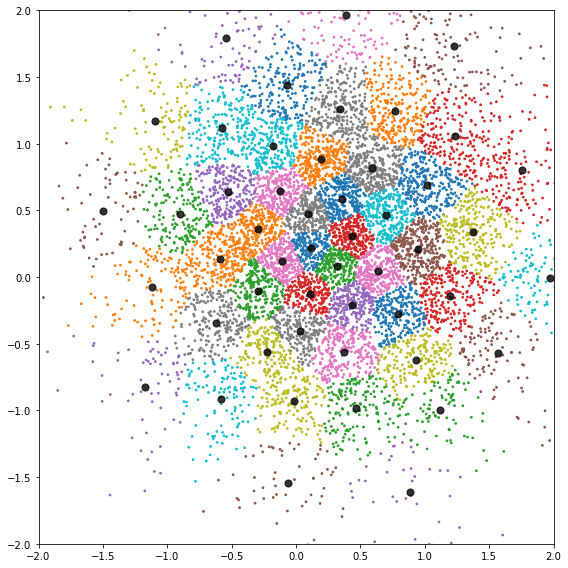

In [6]:
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=50, alpha=0.8)
plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()

KeOps is a versatile library: we can add support for the cosine
similarity with a few lines of code.



In [7]:
def KMeans_cosine(x, K=10, Niter=10, verbose=True):
    """Implements Lloyd's algorithm for the Cosine similarity metric."""

    start = time.time()
    N, D = x.shape  # Number of samples, dimension of the ambient space

    c = x[:K, :].clone()  # Simplistic initialization for the centroids
    # Normalize the centroids for the cosine similarity:
    c = torch.nn.functional.normalize(c, dim=1, p=2)

    x_i = LazyTensor(x.view(N, 1, D))  # (N, 1, D) samples
    c_j = LazyTensor(c.view(1, K, D))  # (1, K, D) centroids

    # K-means loop:
    # - x  is the (N, D) point cloud,
    # - cl is the (N,) vector of class labels
    # - c  is the (K, D) cloud of cluster centroids
    for i in range(Niter):

        # E step: assign points to the closest cluster -------------------------
        S_ij = x_i | c_j  # (N, K) symbolic Gram matrix of dot products
        cl = S_ij.argmax(dim=1).long().view(-1)  # Points -> Nearest cluster

        # M step: update the centroids to the normalized cluster average: ------
        # Compute the sum of points per cluster:
        c.zero_()
        c.scatter_add_(0, cl[:, None].repeat(1, D), x)

        # Normalize the centroids, in place:
        c[:] = torch.nn.functional.normalize(c, dim=1, p=2)

    if verbose:  # Fancy display -----------------------------------------------
        if use_cuda:
            torch.cuda.synchronize()
        end = time.time()
        print(
            f"K-means for the cosine similarity with {N:,} points in dimension {D:,}, K = {K:,}:"
        )
        print(
            "Timing for {} iterations: {:.5f}s = {} x {:.5f}s\n".format(
                Niter, end - start, Niter, (end - start) / Niter
            )
        )

    return cl, c

Timings are similar to the Euclidean case:



In [8]:
cl, c = KMeans_cosine(x, K)

[KeOps] Generating code for formula ArgMax_Reduction(Var(0,2,0)|Var(1,2,1),0) ... OK
[pyKeOps] Compiling pykeops cpp e3ab26f27d module ... OK
K-means for the cosine similarity with 10,000 points in dimension 2, K = 50:
Timing for 10 iterations: 5.80411s = 10 x 0.58041s



Clusters behave as slices around the origin:



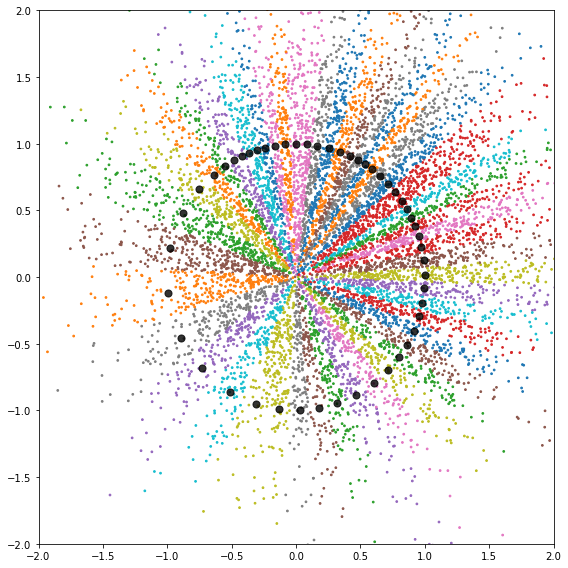

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=50, alpha=0.8)
plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()

## K-means in dimension 100
Second experiment with N=1,000,000 points in dimension D=100, with K=1,000 classes:



In [10]:
if use_cuda:
    N, D, K = 1000000, 100, 1000
    x = torch.randn(N, D, dtype=dtype, device=device_id)
    cl, c = KMeans(x, K)
    cl, c = KMeans_cosine(x, K)

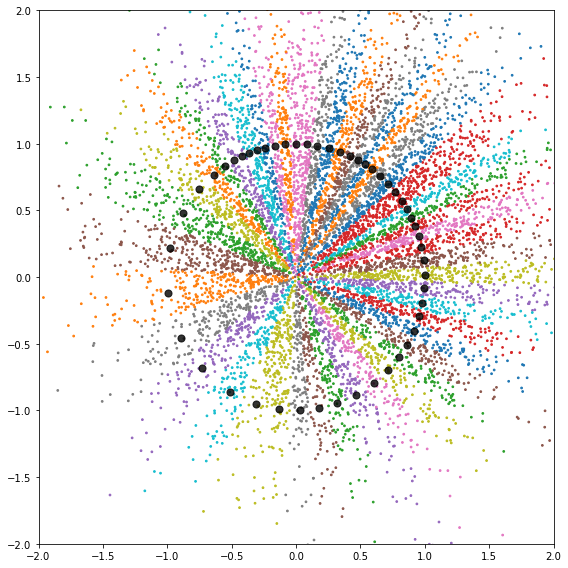

In [11]:
plt.figure(figsize=(8, 8))
plt.scatter(x[:, 0].cpu(), x[:, 1].cpu(), c=cl.cpu(), s=30000 / len(x), cmap="tab10")
plt.scatter(c[:, 0].cpu(), c[:, 1].cpu(), c="black", s=50, alpha=0.8)
plt.axis([-2, 2, -2, 2])
plt.tight_layout()
plt.show()